In [1]:
import pandas
import datetime
import numpy
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [2]:
datFileName = "../data/processedSaps.txt"
sapsDataDF = pandas.read_csv(datFileName, sep=' ')
# add dst_bins
dstBins = [ -150, -75, -50, -25, -10, 10 ]
sapsDataDF = pandas.concat( [ sapsDataDF, \
                    pandas.cut( sapsDataDF["dst_index"], \
                               bins=dstBins ) ], axis=1 )
sapsDataDF.columns = [ "dateStr", "sapsLat", "sapsMLT", \
                      "sapsVel", "radId", "poesLat", "poesMLT", \
                      "dst_date", "dst_index", "time", "dst_bin" ]
sapsDataDF = sapsDataDF.drop(["radId", "poesLat", "poesMLT", "dst_date"], 1)
sapsDataDF.head()

,dateStr,sapsLat,sapsMLT,sapsVel,dst_index,time,dst_bin
0,20110107,56.5,17.7543,308.2077,-18.0,0,"(-25, -10]"
1,20110107,55.5,18.0147,224.1588,-18.0,0,"(-25, -10]"
2,20110107,56.5,17.8749,307.4328,-18.0,0,"(-25, -10]"
3,20110107,55.5,18.1324,222.4787,-18.0,0,"(-25, -10]"
4,20110107,56.5,17.9955,305.4201,-18.0,0,"(-25, -10]"


In [3]:
# calculate prob of occ by dst_bin, MLT, Lat
sapsDataDF["sapsMLTRounded"] = sapsDataDF["sapsMLT"].map(lambda x: round(x) )
# get a normalized form of MLT where 
# if MLT > 12: MLT = MLT - 24, else MLT = MLT
sapsDataDF['normMLT'] = [x-24 if x >= 12 else x for x in sapsDataDF['sapsMLTRounded']]
sapsDataDF['normLAT'] = [x-57.5 for x in sapsDataDF['sapsLat']]
# Get max points at a given Lat, MLT, DstBin
dstGrps = sapsDataDF.groupby(["dst_bin", "sapsMLTRounded", "sapsLat", "normMLT", "normLAT"])
dstSapsMLTLatCountDF = pandas.DataFrame( dstGrps["sapsVel"].count() ).reset_index()
maxCntMLTLatDst = dstSapsMLTLatCountDF.groupby(["dst_bin"]).max().reset_index()
maxCntMLTLatDst = maxCntMLTLatDst.drop(["sapsMLTRounded", "sapsLat", "normMLT", "normLAT"], 1)
maxCntMLTLatDst.columns = ["dst_bin", "maxCount"]
dstSapsMLTLatCountDF = pandas.merge( dstSapsMLTLatCountDF, maxCntMLTLatDst, \
                              on=["dst_bin"], how='inner')
dstSapsMLTLatCountDF.columns = ["dst_bin", "sapsMLT", "sapsLat", "normMLT", "normLAT", "dataCount", "maxCount"]
dstSapsMLTLatCountDF["MLT"] = dstSapsMLTLatCountDF["sapsMLT"].map(lambda x: str(int(x)) )
dstSapsMLTLatCountDF["probOcc"] = dstSapsMLTLatCountDF["dataCount"]/dstSapsMLTLatCountDF["maxCount"]
dstSapsMLTLatCountDF.head()

,dst_bin,sapsMLT,sapsLat,normMLT,normLAT,dataCount,maxCount,MLT,probOcc
0,"(-150, -75]",0.0,51.5,0.0,-6.0,1,333,0,0.003003
1,"(-150, -75]",0.0,52.5,0.0,-5.0,22,333,0,0.066066
2,"(-150, -75]",0.0,53.5,0.0,-4.0,26,333,0,0.078078
3,"(-150, -75]",0.0,54.5,0.0,-3.0,36,333,0,0.108108
4,"(-150, -75]",0.0,55.5,0.0,-2.0,50,333,0,0.150150


In [4]:
# plot the data
saps5075 = dstSapsMLTLatCountDF[ \
                    dstSapsMLTLatCountDF["dst_bin"] == "(-75, -50]" ]
# saps5075 = saps5075[ saps5075["probOcc"] > 0.25 ].reset_index(drop=True)

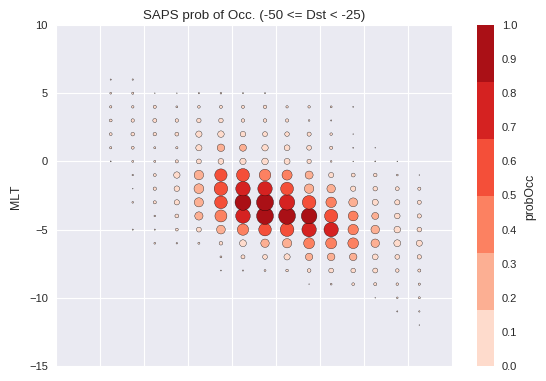

In [5]:
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# Plot using matplotlib
ax = saps5075.plot( kind='scatter',
              x='sapsLat',
              y='normMLT',
              c='probOcc',
              s=saps5075["probOcc"]*150, cmap=seaMap, vmin=0, vmax=1)
ax.set_ylabel("MLT")
ax.set_xlabel("Latitude")
ax.set_title( "SAPS prob of Occ. (-50 <= Dst < -25)" )
# plt.yticks(saps5075["normMLT"].unique(), saps5075["MLT"].unique())
ax.get_figure().savefig("../figs/dst5075prob.pdf",bbox_inches='tight')

In [6]:
def twoD_Gaussian((x, y), amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)    
    a = (numpy.cos(theta)**2)/(2*sigma_x**2) + (numpy.sin(theta)**2)/(2*sigma_y**2)
    b = -(numpy.sin(2*theta))/(4*sigma_x**2) + (numpy.sin(2*theta))/(4*sigma_y**2)
    c = (numpy.sin(theta)**2)/(2*sigma_x**2) + (numpy.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*numpy.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

In [7]:
# initGuess = (3,1,1,2,4,0,1)
# popt, pcov = curve_fit(twoD_Gaussian, (saps5075['normLAT'],saps5075['normMLT']), saps5075['probOcc'],
#                        p0=initGuess)
# print popt

In [8]:
def saps_fun(mLatInp, mltInp):
    x = mLatInp - 57.5
    if mltInp > 12:
        y = mltInp - 24
    else:
        y =mltInp
    (amplitude, xo, yo, sigma_x, sigma_y, theta, offset) = \
        ( 1.02287182, 2.19380912, -2.6933215,\
         1.73397812, 2.72381186, -0.9983568, 0.01633968 )
    xo = float(xo)
    yo = float(yo)    
    a = (numpy.cos(theta)**2)/(2*sigma_x**2) + (numpy.sin(theta)**2)/(2*sigma_y**2)
    b = -(numpy.sin(2*theta))/(4*sigma_x**2) + (numpy.sin(2*theta))/(4*sigma_y**2)
    c = (numpy.sin(theta)**2)/(2*sigma_x**2) + (numpy.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*numpy.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g

In [9]:
pSapsScoreMod = saps_fun(57.5,0)
print pSapsScoreMod

0.420870233102


In [10]:
sapsModelDF = pandas.DataFrame(columns=["normMLT", "normLAT", "probSAPS", "MLT", "Lat"])
latArr = []
mltArr = []
for x in range( int(saps5075["normLAT"].min()), int(saps5075["normLAT"].max()) + 1 ):
    for y in range( int(saps5075["normMLT"].min()), int(saps5075["normMLT"].max()) + 1 ):
        latArr.append(x)
        mltArr.append(y)
sapsModelDF["normMLT"] = mltArr
sapsModelDF["normLAT"] = latArr
sapsModelDF = pandas.merge( sapsModelDF, saps5075, on=["normMLT", "normLAT"], how="outer" )
sapsModelDF["probOcc"] = sapsModelDF["probOcc"].fillna(0.02)
# sapsModelDF = sapsModelDF[ ["normMLT", "normLAT", "probOcc"] ]
sapsModelDF.head()

,normMLT,normLAT,probSAPS,MLT_x,Lat,dst_bin,sapsMLT,sapsLat,dataCount,maxCount,MLT_y,probOcc
0,-12,-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02
1,-11,-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02
2,-10,-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02
3,-9,-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02
4,-8,-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02


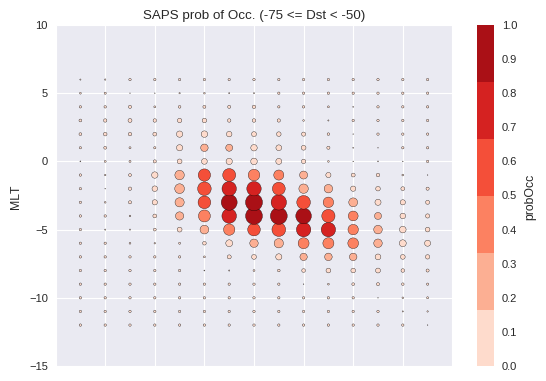

In [11]:
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# Plot using matplotlib
ax = sapsModelDF.plot( kind='scatter',
              x='normLAT',
              y='normMLT',
              c='probOcc',
              s=sapsModelDF["probOcc"]*150, cmap=seaMap, vmin=0, vmax=1)
ax.set_ylabel("MLT")
ax.set_xlabel("Latitude")
ax.set_title( "SAPS prob of Occ. (-75 <= Dst < -50)" )
ax.get_figure().savefig("../figs/fulldst5075prob.pdf",bbox_inches='tight')

In [12]:
initGuess = (3,1,1,2,4,0,1)
popt2, pcov2 = curve_fit(twoD_Gaussian, (sapsModelDF['normLAT'],sapsModelDF['normMLT']), sapsModelDF['probOcc'],
                       p0=initGuess)
#amplitude, xo, yo, sigma_x, sigma_y, theta, offset
# offset + amplitude*numpy.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
#                             + c*((y-yo)**2)))
print popt2 

[ 0.99277339  0.56183913 -3.488714    1.49141158  2.76582389 -1.01041474
  0.02019752]
